In [2]:
import sys
sys.path.append("..")
import argparse
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn import metrics

import torch
import torch.nn as nn
import copy
import model
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import st_loss

import h5py
import scipy as sp
import scanpy.api as sc
from collections import Counter
import random
import utils
import loop
import pickle
import train
import os
import glob2
plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
path = "../"
files = glob2.glob(f'{path}real_data/*.h5')
files = [f[len(f"'{path}real_data"):-3] for f in files]
files

['10X_PBMC_select_2100',
 'mouse_ES_cell',
 'worm_neuron_cell_select_2100',
 'worm_neuron_cell',
 'mouse_bladder_cell',
 'mouse_ES_cell_select_2100',
 'mouse_bladder_cell_select_2100',
 '10X_PBMC']

In [5]:
files = [
    '10X_PBMC',
    '10X_PBMC_select_2100',
    'mouse_ES_cell',
    'mouse_ES_cell_select_2100',
    'worm_neuron_cell_select_2100',
    'worm_neuron_cell',
    'mouse_bladder_cell',
    'mouse_bladder_cell_select_2100',

]

In [4]:
df = pd.DataFrame()
for run in range(3):    
    print(df.shape)
    for dataset in files:
        torch.manual_seed(run)
        torch.cuda.manual_seed_all(run)
        np.random.seed(run)
        random.seed(run)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        print(f">>>>> Data {dataset}")

        data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        print(np.where(X ==0)[0].shape[0]/(X.shape[0]*X.shape[1]))
        cluster_number = np.unique(Y).shape[0]
        nb_genes = 1500
        data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])


        X = train.preprocess(X, nb_genes = nb_genes)

        dresults = train.train(X,
                               cluster_number,
                               dataset,
                               Y,
                               n_ensemble=3,
                               epochs=100,
                               nb_zeros = "random",
                               save_to=f"{path}output/real_data/{run}/")
        
        pxt = PCA(2).fit_transform(X)
        dresults ["original"] = utils.evaluate(X, Y, cluster_number)[1]
        dresults ["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
        dresults ["run"] = run
        print(dresults)
        df = df.append(dresults, ignore_index=True)
    df.to_pickle(f"{path}output/pickle_results/real_data.pkl")

(0, 0)
>>>>> Data 10X_PBMC
0.9223690984556294
(4271, 16653) (4271, 16653) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.47276986960113415, 'leiden_representation_0': 0.41442221416300107, 'kmeans_representation_1': 0.4021831439806861, 'leiden_representation_1': 0.5719399229746117, 'kmeans_representation_2': 0.44491720234874704, 'leiden_representation_2': 0.5207437433532698, 'COMBINED_kmeans': 0.5776214497560284, 'COMBINED_leiden': 0.713075599579578, 'network_0': 0.48652029619206605, 'network_1': 0.43415120352769987, 'network_2': 0.470335396362339, 'dataset': '10X_PBMC', 'cluster_number': 8, 'original': 0.57814, 'pca': 0.22207, 'run': 0}
>>>>> Data 10X_PBMC_select_2100
0.922900120956327
(2100, 16653) (2100, 16653) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.3887185700687892, 'leiden_representation_0': 0.4227009536236139, 'kmeans_representation_1': 0.4214590351847921, 'leiden_representation_1': 0.45398566189852135, 

0.9861758600237248
(2100, 13488) (2100, 13488) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.22651174921801878, 'leiden_representation_0': 0.22760486368423466, 'kmeans_representation_1': 0.2465317773677702, 'leiden_representation_1': 0.24033818232285348, 'kmeans_representation_2': 0.20859114950170923, 'leiden_representation_2': 0.20640282487090264, 'COMBINED_kmeans': 0.41891523733647634, 'COMBINED_leiden': 0.346380211107125, 'network_0': 0.21433384131550054, 'network_1': 0.2502467236946796, 'network_2': 0.20987104049121208, 'dataset': 'worm_neuron_cell_select_2100', 'cluster_number': 10, 'original': 0.04622, 'pca': 0.18792, 'run': 1}
>>>>> Data worm_neuron_cell
0.9861813427688408
(4186, 13488) (4186, 13488) keeping 1500 genes
..........|..........|..........|{'kmeans_representation_0': 0.3221804010516614, 'leiden_representation_0': 0.31192054466330277, 'kmeans_representation_1': 0.2876068556972322, 'leiden_representation_1': 0.29989904841522186, 'kme

In [8]:
df.groupby("dataset").mean()

,COMBINED_kmeans,COMBINED_leiden,cluster_number,kmeans_representation_0,kmeans_representation_1,kmeans_representation_2,leiden_representation_0,leiden_representation_1,leiden_representation_2,network_0,network_1,network_2,original,pca,run
dataset,,,,,,,,,,,,,,,
10X_PBMC,0.588540,0.627008,8.0,0.466850,0.469963,0.446851,0.499781,0.544616,0.506420,0.491784,0.495597,0.476785,0.57814,0.222070,1.0
10X_PBMC_select_2100,0.585675,0.677475,8.0,0.411139,0.403303,0.395940,0.430690,0.399965,0.444710,0.428437,0.429641,0.424625,0.62993,0.340020,1.0
mouse_ES_cell,0.656451,0.657683,4.0,0.577322,0.535115,0.598454,0.267430,0.336905,0.252951,0.015680,0.014347,0.019242,0.72291,0.753120,1.0
mouse_ES_cell_select_2100,0.740503,0.631700,4.0,0.666233,0.657164,0.617683,0.270213,0.264420,0.241616,0.684403,0.654086,0.641248,0.88681,0.747770,1.0
mouse_bladder_cell,0.383103,0.546637,16.0,0.308297,0.284833,0.300067,0.424292,0.410685,0.441712,0.338912,0.311335,0.334603,0.40146,0.366040,1.0
mouse_bladder_cell_select_2100,0.397222,0.576974,16.0,0.289732,0.297726,0.279070,0.422484,0.412812,0.425227,0.314779,0.323474,0.316475,0.36022,0.394420,1.0
worm_neuron_cell,0.429629,0.352147,10.0,0.302245,0.300068,0.308680,0.305906,0.304478,0.300815,0.301407,0.300815,0.303556,0.08392,0.190820,1.0
worm_neuron_cell_select_2100,0.438779,0.358964,10.0,0.235817,0.202157,0.216726,0.231066,0.220232,0.203572,0.232956,0.210835,0.217244,0.04622,0.185043,1.0


# Importance of input size

In [21]:
df = pd.DataFrame(
    columns=["dataset","perc0", "nb_genes", "exp", "ari"])
print(df.shape)
for dataset in files:

    print(f">>>>> Data {dataset}")

    data_mat = h5py.File(f"{path}real_data/{dataset}.h5", "r")
    for nb_genes in [100, 200, 500, 1000, 1500]:
        
        X = np.array(data_mat['X'])
        Y = np.array(data_mat['Y'])
        perc_0 = np.where(X == 0)[0].shape[0] / (X.shape[0] * X.shape[1])
        print(f"Perc 0 {perc_0}")
        cluster_number = np.unique(Y).shape[0]


        X = train.preprocess(X, nb_genes = nb_genes)
        nb_zeros = int(0.8 * nb_genes)
        dresults = train.train(X,
                               cluster_number,
                               dataset,
                               Y,
                               n_ensemble=1,
                               epochs=100,
                               nb_zeros = nb_zeros,
                               save_to=f"{path}output/real_data/inputs/{dataset}_{nb_genes}/")

        df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'kmeans_representation_0',dresults['kmeans_representation_0']
            ]
        df.loc[df.shape[0]] = [
                dataset, perc_0, nb_genes, 'leiden_representation_0',dresults['leiden_representation_0']
            ]
        pxt = PCA(2).fit_transform(X)
        dresults ["original"] = utils.evaluate(X, Y, cluster_number)[1]
        dresults ["pca"] = utils.evaluate(pxt, Y, cluster_number)[1]
        print(dresults)
    df.to_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

(80, 5)
>>>>> Data 10X_PBMC
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 2500 genes
..........|{'kmeans_representation_0': 0.7607193682549783, 'leiden_representation_0': 0.5626879597411804, 'COMBINED_kmeans': 0.7607193682549783, 'COMBINED_leiden': 0.5626879597411804, 'network_0': 0.6755089271680721, 'dataset': '10X_PBMC', 'cluster_number': 8, 'original': 0.64456, 'pca': 0.57428}
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 5000 genes
..........|{'kmeans_representation_0': 0.7037641353270853, 'leiden_representation_0': 0.7406934621402164, 'COMBINED_kmeans': 0.7037641353270853, 'COMBINED_leiden': 0.7406934621402164, 'network_0': 0.6543857693869103, 'dataset': '10X_PBMC', 'cluster_number': 8, 'original': 0.64707, 'pca': 0.72238}
Perc 0 0.9223690984556294
(4271, 16653) (4271, 16653) keeping 8000 genes
..........|{'kmeans_representation_0': 0.581792983242919, 'leiden_representation_0': 0.7217816119230988, 'COMBINED_kmeans': 0.581792983242919, 'COMBINED_leid

Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 2500 genes
..........|{'kmeans_representation_0': 0.43474073218905274, 'leiden_representation_0': 0.5696846857288858, 'COMBINED_kmeans': 0.43474073218905274, 'COMBINED_leiden': 0.5696846857288858, 'network_0': 0.44603652879385064, 'dataset': 'mouse_bladder_cell_select_2100', 'cluster_number': 16, 'original': 0.47866, 'pca': 0.36064}
Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 5000 genes
..........|{'kmeans_representation_0': 0.3631509588503264, 'leiden_representation_0': 0.5448580043938016, 'COMBINED_kmeans': 0.3631509588503264, 'COMBINED_leiden': 0.5448580043938016, 'network_0': 0.34710994378493043, 'dataset': 'mouse_bladder_cell_select_2100', 'cluster_number': 16, 'original': 0.34231, 'pca': 0.33597}
Perc 0 0.9489742437855645
(2100, 20670) (2100, 20670) keeping 8000 genes
..........|{'kmeans_representation_0': 0.333725872177902, 'leiden_representation_0': 0.5066506576124868, 'COMBINED_kmeans': 0.333725872

In [17]:
df = pd.read_pickle(f"{path}output/pickle_results/real_data_input_size.pkl")

In [18]:
df.groupby(["nb_genes"]).mean()

,perc0,ari
nb_genes,,
100,0.879082,0.267377
200,0.879082,0.349070
500,0.879082,0.429662
1000,0.879082,0.494762
1500,0.879082,0.520171
2500,0.879082,0.547937
5000,0.879082,0.530802
8000,0.879082,0.507037


In [19]:
dataset_names = {
    '10X_PBMC': '10X PBMC',
    '10X_PBMC_select_2100': '10X PBMC (2100)',
    'mouse_ES_cell': 'Mouse ES\nCell',
    'mouse_ES_cell_select_2100': 'Mouse ES\nCell (2100)',
    'worm_neuron_cell_select_2100': 'Worm Neuron\nCell (2100)',
    'worm_neuron_cell': 'Worm Neuron\nCell',
    'mouse_bladder_cell': 'Mouse Bladder\nCell',
    'mouse_bladder_cell_select_2100': 'Mouse Bladder\n Cell (2100)'
}

df["dataset"] = df["dataset"].apply(lambda x: dataset_names[x])

df = df.rename(columns = {"nb_genes": "Nb input genes"})

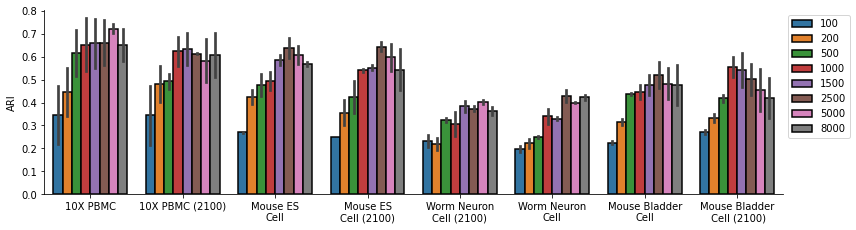

In [25]:
import seaborn as sns

plt.figure(figsize=(12, 3.3))
ax = plt.subplot(111)
sns.barplot(
    hue="Nb input genes",
    y="ari",
    x="dataset",
    data=df,
    ax=ax,
    edgecolor='black',
    linewidth=1.5,
)
plt.ylabel("ARI")
plt.xlabel("")
plt.legend(bbox_to_anchor=(1, 1))
sns.despine()
plt.tight_layout()

plt.savefig(f"{path}diagrams/real_input_size.pdf", bbox_inches='tight')